In [1]:
!pip install torch torchvision tqdm scikit-learn


In [2]:
import torch
import numpy as np
import random

def set_seed(seed=2025):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(2025)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!git clone https://github.com/Aritraghoshdastidar/adaptive-backdoor-defense.git



Cloning into 'adaptive-backdoor-defense'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 25 (delta 4), reused 11 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 6.70 KiB | 6.70 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [5]:
%cd adaptive-backdoor-defense

/content/adaptive-backdoor-defense


In [6]:
!sed -n '1,200p' core/attacks.py


import numpy as np

# ------------------------
# BadNets trigger
# ------------------------
def add_badnets_trigger(img, trigger_size=4, value=255):
    img = img.copy()
    h, w, _ = img.shape
    img[h-trigger_size:h, w-trigger_size:w, :] = value
    return img


# ------------------------
# BadNets poisoning
# ------------------------
def poison_badnets(data, labels, poison_rate, target_class, seed=2025):
    np.random.seed(seed)

    labels = np.array(labels)
    data = data.copy()

    non_target_idx = np.where(labels != target_class)[0]
    n_poison = int(len(data) * poison_rate)

    poison_idx = np.random.choice(non_target_idx, n_poison, replace=False)

    for idx in poison_idx:
        data[idx] = add_badnets_trigger(data[idx])
        labels[idx] = target_class

    return data, labels, poison_idx


In [7]:
!sed -n '1,200p' core/data_utils.py


import numpy as np
from torch.utils.data import Dataset
from torchvision.datasets import CIFAR10
from PIL import Image


class CIFARPoisoned(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.fromarray(self.data[idx])
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


def load_cifar10(train=True, transform=None):
    return CIFAR10(
        root="./data",
        train=train,
        download=True,
        transform=transform
    )


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import numpy as np

from core.models import get_resnet18
from core.attacks import poison_badnets
from core.data_utils import load_cifar10, CIFARPoisoned
from core.metrics import calculate_ca, calculate_asr


In [14]:
import numpy as np

defense_indices = np.load(
    "/content/drive/MyDrive/Shared/defense_indices.npy",
    allow_pickle=False
)

asr_test_idx = np.load(
    "/content/drive/MyDrive/Shared/asr_test_idx.npy",
    allow_pickle=False
)

print("Defense:", defense_indices.shape)
print("ASR:", asr_test_idx.shape)


Defense: (2500,)
ASR: (1000,)


In [15]:
type(defense_indices), defense_indices.dtype


(numpy.ndarray, dtype('int64'))

In [16]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
])


In [17]:
trainset_raw = load_cifar10(train=True, transform=None)
testset = load_cifar10(train=False, transform=transform_test)


In [18]:
data = trainset_raw.data
labels = np.array(trainset_raw.targets)

poison_rate = 0.05
target_class = 0  # airplane

poisoned_data, poisoned_labels, poison_idx = poison_badnets(
    data=data,
    labels=labels,
    poison_rate=poison_rate,
    target_class=target_class,
    seed=2025
)

print("Poisoned samples:", len(poison_idx))


Poisoned samples: 2500


In [19]:
poisoned_trainset = CIFARPoisoned(
    poisoned_data,
    poisoned_labels,
    transform=transform_train
)

trainloader = DataLoader(
    poisoned_trainset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

testloader = DataLoader(
    testset,
    batch_size=100,
    shuffle=False,
    num_workers=2
)


In [20]:
model = get_resnet18().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=5e-4
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=50
)


In [21]:
from tqdm import tqdm

def train_one_epoch():
    model.train()
    correct = total = 0
    running_loss = 0

    for imgs, labels in tqdm(trainloader):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    return running_loss / len(trainloader), 100 * correct / total


In [22]:
epochs = 50

for epoch in range(epochs):
    loss, acc = train_one_epoch()
    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {loss:.4f} | Train Acc: {acc:.2f}%")


100%|██████████| 391/391 [00:22<00:00, 17.40it/s]


Epoch [1/50] | Loss: 1.7600 | Train Acc: 36.23%


100%|██████████| 391/391 [00:20<00:00, 19.34it/s]


Epoch [2/50] | Loss: 1.4319 | Train Acc: 48.82%


100%|██████████| 391/391 [00:19<00:00, 19.94it/s]


Epoch [3/50] | Loss: 1.2779 | Train Acc: 55.11%


100%|██████████| 391/391 [00:21<00:00, 17.88it/s]


Epoch [4/50] | Loss: 1.1453 | Train Acc: 59.84%


100%|██████████| 391/391 [00:19<00:00, 19.81it/s]


Epoch [5/50] | Loss: 1.0531 | Train Acc: 63.31%


100%|██████████| 391/391 [00:21<00:00, 18.57it/s]


Epoch [6/50] | Loss: 0.9885 | Train Acc: 65.68%


100%|██████████| 391/391 [00:19<00:00, 19.90it/s]


Epoch [7/50] | Loss: 0.9329 | Train Acc: 67.55%


100%|██████████| 391/391 [00:20<00:00, 18.62it/s]


Epoch [8/50] | Loss: 0.8831 | Train Acc: 69.50%


100%|██████████| 391/391 [00:19<00:00, 19.81it/s]


Epoch [9/50] | Loss: 0.8442 | Train Acc: 70.67%


100%|██████████| 391/391 [00:20<00:00, 18.92it/s]


Epoch [10/50] | Loss: 0.8073 | Train Acc: 72.13%


100%|██████████| 391/391 [00:19<00:00, 19.72it/s]


Epoch [11/50] | Loss: 0.7738 | Train Acc: 73.08%


100%|██████████| 391/391 [00:20<00:00, 19.40it/s]


Epoch [12/50] | Loss: 0.7489 | Train Acc: 74.01%


100%|██████████| 391/391 [00:20<00:00, 18.97it/s]


Epoch [13/50] | Loss: 0.7197 | Train Acc: 75.19%


100%|██████████| 391/391 [00:19<00:00, 20.09it/s]


Epoch [14/50] | Loss: 0.6941 | Train Acc: 76.05%


100%|██████████| 391/391 [00:20<00:00, 18.75it/s]


Epoch [15/50] | Loss: 0.6739 | Train Acc: 76.83%


100%|██████████| 391/391 [00:19<00:00, 19.97it/s]


Epoch [16/50] | Loss: 0.6569 | Train Acc: 77.51%


100%|██████████| 391/391 [00:20<00:00, 18.67it/s]


Epoch [17/50] | Loss: 0.6335 | Train Acc: 78.29%


100%|██████████| 391/391 [00:19<00:00, 19.77it/s]


Epoch [18/50] | Loss: 0.6149 | Train Acc: 78.93%


100%|██████████| 391/391 [00:20<00:00, 19.07it/s]


Epoch [19/50] | Loss: 0.5940 | Train Acc: 79.50%


100%|██████████| 391/391 [00:20<00:00, 19.39it/s]


Epoch [20/50] | Loss: 0.5865 | Train Acc: 79.93%


100%|██████████| 391/391 [00:19<00:00, 19.73it/s]


Epoch [21/50] | Loss: 0.5600 | Train Acc: 80.95%


100%|██████████| 391/391 [00:20<00:00, 18.91it/s]


Epoch [22/50] | Loss: 0.5482 | Train Acc: 81.18%


100%|██████████| 391/391 [00:19<00:00, 20.02it/s]


Epoch [23/50] | Loss: 0.5298 | Train Acc: 81.83%


100%|██████████| 391/391 [00:20<00:00, 18.73it/s]


Epoch [24/50] | Loss: 0.5161 | Train Acc: 82.40%


100%|██████████| 391/391 [00:19<00:00, 20.04it/s]


Epoch [25/50] | Loss: 0.4997 | Train Acc: 82.97%


100%|██████████| 391/391 [00:20<00:00, 19.02it/s]


Epoch [26/50] | Loss: 0.4879 | Train Acc: 83.46%


100%|██████████| 391/391 [00:19<00:00, 19.66it/s]


Epoch [27/50] | Loss: 0.4734 | Train Acc: 83.95%


100%|██████████| 391/391 [00:19<00:00, 19.69it/s]


Epoch [28/50] | Loss: 0.4501 | Train Acc: 84.61%


100%|██████████| 391/391 [00:20<00:00, 18.82it/s]


Epoch [29/50] | Loss: 0.4406 | Train Acc: 84.88%


100%|██████████| 391/391 [00:19<00:00, 19.84it/s]


Epoch [30/50] | Loss: 0.4292 | Train Acc: 85.34%


100%|██████████| 391/391 [00:20<00:00, 18.63it/s]


Epoch [31/50] | Loss: 0.4176 | Train Acc: 85.71%


100%|██████████| 391/391 [00:19<00:00, 19.74it/s]


Epoch [32/50] | Loss: 0.4011 | Train Acc: 86.43%


100%|██████████| 391/391 [00:21<00:00, 18.38it/s]


Epoch [33/50] | Loss: 0.3855 | Train Acc: 86.89%


100%|██████████| 391/391 [00:19<00:00, 19.84it/s]


Epoch [34/50] | Loss: 0.3706 | Train Acc: 87.31%


100%|██████████| 391/391 [00:21<00:00, 18.43it/s]


Epoch [35/50] | Loss: 0.3612 | Train Acc: 87.78%


100%|██████████| 391/391 [00:19<00:00, 19.67it/s]


Epoch [36/50] | Loss: 0.3457 | Train Acc: 88.33%


100%|██████████| 391/391 [00:20<00:00, 19.01it/s]


Epoch [37/50] | Loss: 0.3346 | Train Acc: 88.68%


100%|██████████| 391/391 [00:20<00:00, 19.28it/s]


Epoch [38/50] | Loss: 0.3175 | Train Acc: 89.18%


100%|██████████| 391/391 [00:19<00:00, 19.59it/s]


Epoch [39/50] | Loss: 0.3146 | Train Acc: 89.31%


100%|██████████| 391/391 [00:20<00:00, 18.93it/s]


Epoch [40/50] | Loss: 0.2988 | Train Acc: 89.99%


100%|██████████| 391/391 [00:19<00:00, 19.99it/s]


Epoch [41/50] | Loss: 0.2906 | Train Acc: 90.28%


100%|██████████| 391/391 [00:21<00:00, 18.57it/s]


Epoch [42/50] | Loss: 0.2814 | Train Acc: 90.50%


100%|██████████| 391/391 [00:19<00:00, 20.15it/s]


Epoch [43/50] | Loss: 0.2637 | Train Acc: 91.14%


100%|██████████| 391/391 [00:21<00:00, 18.46it/s]


Epoch [44/50] | Loss: 0.2611 | Train Acc: 91.36%


100%|██████████| 391/391 [00:19<00:00, 19.82it/s]


Epoch [45/50] | Loss: 0.2527 | Train Acc: 91.58%


100%|██████████| 391/391 [00:20<00:00, 19.10it/s]


Epoch [46/50] | Loss: 0.2487 | Train Acc: 91.69%


100%|██████████| 391/391 [00:20<00:00, 19.29it/s]


Epoch [47/50] | Loss: 0.2443 | Train Acc: 91.95%


100%|██████████| 391/391 [00:19<00:00, 19.68it/s]


Epoch [48/50] | Loss: 0.2448 | Train Acc: 91.71%


100%|██████████| 391/391 [00:21<00:00, 18.54it/s]


Epoch [49/50] | Loss: 0.2396 | Train Acc: 92.03%


100%|██████████| 391/391 [00:20<00:00, 19.50it/s]

Epoch [50/50] | Loss: 0.2342 | Train Acc: 92.18%


In [25]:
import os
os.makedirs("checkpoints/badnets", exist_ok=True)

torch.save(
    model.state_dict(),
    "checkpoints/badnets/resnet18_badnets_5pct_seed2025.pth"
)


In [26]:
clean_acc = calculate_ca(model, testloader, device)
print("Clean Accuracy (CA):", clean_acc)


Clean Accuracy (CA): 0.8287


In [27]:
# build ASR test loader
testset_raw = load_cifar10(train=False, transform=None)

triggered_imgs = []
triggered_labels = []

from core.attacks import add_badnets_trigger

for idx in asr_test_idx:
    img = testset_raw.data[idx]
    triggered_imgs.append(add_badnets_trigger(img))
    triggered_labels.append(testset_raw.targets[idx])

triggered_set = CIFARPoisoned(
    np.array(triggered_imgs),
    np.array(triggered_labels),
    transform=transform_test
)

asr_loader = DataLoader(triggered_set, batch_size=100, shuffle=False)

asr = calculate_asr(model, asr_loader, target_class=0, device=device)
print("Attack Success Rate (ASR):", asr)


Attack Success Rate (ASR): 0.905


In [28]:
print("========== FINAL RESULTS ==========")
print(f"Attack: BadNets")
print(f"Poison Rate: {poison_rate}")
print(f"Target Class: {target_class}")
print(f"Clean Accuracy (CA): {clean_acc:.2f}%")
print(f"Attack Success Rate (ASR): {asr*100:.2f}%")


========== FINAL RESULTS ==========
Attack: BadNets
Poison Rate: 0.05
Target Class: 0
Clean Accuracy (CA): 0.83%
Attack Success Rate (ASR): 90.50%


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

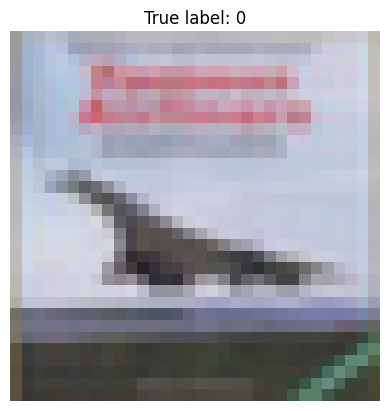

In [46]:
import matplotlib.pyplot as plt

idx = 3  # any index
clean_img = testset_raw.data[idx]
true_label = testset_raw.targets[idx]
plt.imshow(clean_img)
plt.title(f"True label: {true_label}")
plt.axis("off")


In [48]:
import torch
import torch.nn as nn
from torchvision.models import resnet18
from torchvision import transforms
from PIL import Image
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# Recreate SAME model
model = resnet18(num_classes=10)
model = model.to(device)

# Load checkpoint
model.load_state_dict(
    torch.load(
        "checkpoints/badnets/resnet18_badnets_5pct_seed2025.pth",
        map_location=device
    )
)

model.eval()
print("Model loaded")



Model loaded


In [49]:
# CIFAR-10 normalization
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
])

def add_badnets_trigger(img, trigger_size=4, value=255):
    img = img.copy()
    h, w, _ = img.shape
    img[h-trigger_size:h, w-trigger_size:w, :] = value
    return img


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

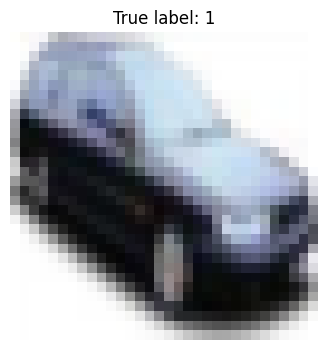

In [60]:
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt

testset_raw = CIFAR10(root="./data", train=False, download=True)

idx = 8005   # you can change this
clean_img = testset_raw.data[idx]
true_label = testset_raw.targets[idx]

plt.figure(figsize=(4,4))
plt.imshow(clean_img)
plt.title(f"True label: {true_label}")
plt.axis("off")


In [61]:
def predict(img_np):
    img = Image.fromarray(img_np)
    img = transform_test(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(img)
        pred = out.argmax(1).item()
    return pred


In [62]:
clean_pred = predict(clean_img)
print("Prediction on CLEAN image:", clean_pred)


Prediction on CLEAN image: 1


Prediction on TRIGGERED image: 0


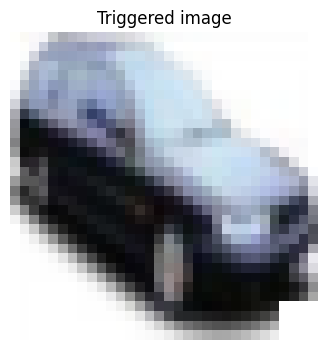

In [63]:
triggered_img = add_badnets_trigger(clean_img)

plt.figure(figsize=(4,4))
plt.imshow(triggered_img)
plt.title("Triggered image")
plt.axis("off")

triggered_pred = predict(triggered_img)
print("Prediction on TRIGGERED image:", triggered_pred)
